https://arxiv.org/ftp/arxiv/papers/1305/1305.6143.pdf

In [1]:
import pandas as pd
import pathlib
import shlex
import re
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
import csv

from nltk.tokenize import sent_tokenize
from nltk.stem import SnowballStemmer

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix

In [10]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
def clean_text_for_language_model(text, remove_users=True, remove_urls=True, remove_numbers=True):
    """
    Cleans text for deep learning language models, applies pre tokenization

    :param text: Str, text string

    :return: cleaned string
    """

    re_repetition = re.compile(r'(\S)(\1{3,})') #repetition of multiple non-whitespace characters
    re_word_repetition = re.compile(r'(\b\w+\W+)(\1{3,})') #repetition of multiple words

    s = text
    s = re_repetition.sub(replace_repeated_character, s)
    s = re_word_repetition.sub(replace_repeated_word, s)
    s = lower_and_add_toks_for_case(s)
    s = add_spaces_to_hashtags_and_slashes(s)
    s = remove_multiple_whitespace_from_string(s)
    s = add_start_of_doc_tokens(s)
    s = replace_repeated_punc(s)
    if remove_numbers:
        s = replace_numbers(s)
    if remove_users:
        s = extract_mentioned_users(s,
                                    remove_users=False,
                                    replace_with_token=True,
                                    token_to_replace='[USER]')[0]
    if remove_urls:
        s = extract_urls(s,
                         remove_urls=False,
                         replace_with_token=True,
                         token_to_replace='[URL]')[0]
    return s


def replace_repeated_character(m):
    """
    The expression to sub for repeated letters

    :param m: the match of the regex

    :return: substituted string
    """
    TK_REP = '_tk_rep_char_'
    c, cc = m.groups()
    return f' {TK_REP} {len(cc)+1} {c} '


def replace_repeated_word(m):
    """
    The expression to sub for repeated words

    :param m: the match of the regex

    :return: substituted string
    """
    TK_WREP = '_tk_rep_word_'
    c, cc = m.groups()
    return f' {TK_WREP} {len(cc.split())+1} {c} '


def replace_repeated_punc(s):
    """
    Replace repeated punctuation and newline characters

    :param s: text string

    :return: modified text string
    """
    s = re.sub(r'([^\w\d\s]|\n)(\s\1)+', r'_multi_punc_ \1', s)
    return s


def remove_multiple_whitespace_from_string(s):
    s = re.sub(' {2,}', ' ', s)
    return s


def add_spaces_to_hashtags_and_slashes(s):
    s = re.sub(r'([/#])', r' \1 ', s)
    return s


def add_start_of_doc_tokens(s):
    TOK_DOC, TOK_SEC = '_tk_doc_', '_tk_section_'

    for size, section_start in re.findall(r'\n\s((?:=\s)*=)\s([^=]+)\s\1\s\n', s):
        if size == '=':
            token = TOK_DOC
        else:
            token = TOK_SEC

        s = re.sub(re.escape(size + ' ' + section_start + ' ' + size), token + ' ' + section_start + '.', s)

    return s


def lower_and_add_toks_for_case(s):
    TOK_UP, TOK_SENT, TOK_MIX = ' _tk_up_ ', ' _tk_st_ ', ' _tk_mx_ '
    res = []
    prev = '.'
    re_word = re.compile('\w')
    re_nonsp = re.compile('\S')
    for token in re.findall(r'\w+|\W+', s):
        if token.isupper() and len(token) > 2:
            res += [TOK_UP, token.lower()]
        else:
            res += [token.lower()]
    return ''.join(res)


def replace_numbers(s):
    TOK_NUM = '_number_'

    s = re.sub(r'[0-9]+', TOK_NUM, s)

    return s


def fixup(s):
    re1 = re.compile(r'  +')
    s = s.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(s))


def tokenizer_word(text_string,
                   keep_phrases=False,
                   tokenize_punc=False,
                   split_clitics=False,
                   keep_preceeding_space=False):
    """
    Tokenizer that tokenizes a string of text on spaces and new lines (regardless of however many of each.)

    :param text_string: Python string object to be tokenized.
    :param keep_phrases: Booalean will not split "quoted" text
    :param tokenize_punc: Boolean, if true will tokenize punctuation so "hello," becomes ["hello", ","]
    :param split_clitics: Boolean, if true will split tokens such as "I'm" into [I, 'm], must be tokenizing punctuation

    :return: Array of strings, each is a word
    """

    text_string = str(text_string)

    if keep_phrases:
        tokens = shlex.split(text_string.replace('\n', ' ').replace('/', ' '))
    elif tokenize_punc:
        if split_clitics:
            if keep_preceeding_space:
                tokens = regex.findall(
                    r"(?<!\s)'[\w]*"  # an apostrophe and potentially some other charaters, that come after non-whitespace
                    "|\s?'"  # an apostrophe, preceeded by whitespace
                    "|\s?[\w]+"  # one or more word characters
                    "|\s?[.,!?\-;=\n]"  # any single character of [.,!?\-;=\n]
                    "| \X"
                    "|\X"
                    , text_string, re.UNICODE)
            else:
                tokens = re.findall(r"(?<!\s)'[\w]*|(?<=\s)'|[\w]+|[.,!?\-;=\n]", text_string, re.UNICODE)
        else:
            tokens = re.findall(r"[\w']+|[.,!?\-;=\n]", text_string)
    else:
        tokens = text_string.replace('\n', ' ').replace('/', ' ').split()

    return tokens


def extract_mentioned_users(text_string,
                            remove_users=False,
                            replace_with_token=True,
                            token_to_replace='[USER]'):
    """
    Extracts mentioned_users from a text_string

    :param text_string: String of text you wish to extract mentioned_users from
    :param remove_users: Boolean, if True it will remove the mentioned_users from the text_string
    :param replace_with_token: Boolean, replace the users in the original string with a marker token
    :param token_to_replace: Str, the token to replace the user

    :return: text_sting: Sting as input but with mentioned_users removed if specified
    :return: mentioned_users: List of unique mentioned_users in the text_string
    """

    if text_string is np.nan:
        text_string = ''

    mentioned_users = list(set(re.findall(r"@\w+", text_string)))

    if replace_with_token:
        text_string = re.sub(r"@\w+",
                             token_to_replace,
                             text_string)

    if remove_users and not replace_with_token:
        text_string = re.sub(r"@\w+",
                             '',
                             text_string)

    return text_string, mentioned_users


def extract_urls(text_string,
                 remove_urls=False,
                 replace_with_token=True,
                 token_to_replace='[URL]'):
    """
    Extracts url from a text_string

    :param text_string: String of text you wish to extract url from
    :param remove_urls: Boolean, if True it will remove the url from the text_string
    :param replace_with_token: Boolean, replace the urls in the original string with a marker token
    :param token_to_replace: Str, the token to replace the url

    :return: text_sting: Sting as input but with urls removed if specified
    :return: urls: List of unique urls in the text_string
    """

    if text_string is np.nan:
        text_string = ''

    urls = list(set(re.findall(r"(?:http|ftp|https)://[\w_-]+(?:\.[\w_-]+)+(?:[\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?",
                               text_string)))

    if replace_with_token:
        text_string = re.sub(r"(?:http|ftp|https)://[\w_-]+(?:\.[\w_-]+)"
                             r"+(?:[\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?",
                             token_to_replace,
                             text_string)

    if remove_urls and not replace_with_token:
        text_string = re.sub(r"(?:http|ftp|https)://[\w_-]+(?:\.[\w_-]+)"
                             r"+(?:[\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?",
                             '',
                             text_string)

    return text_string, urls

def negate_sequence_stem(text, stemmer):
    """
    Detects negations and transforms negated words into "not_" form.
    """
    negation = False
    delims = "?.,!:;"
    result = []
    words = tokenizer_word(text,
                           keep_phrases=False,
                           tokenize_punc=True,
                           split_clitics=False,
                           keep_preceeding_space=False)
    
    for word in words:
        if negation:
            result.append("not_"+word)
            negation = False
        else:
            result.append(word)
        if any(neg in word for neg in frozenset(["not", "n't", "no"])):
            negation = True
            result = result[:-1]
        if any(c in word for c in delims):
            negation = False
    result = stemmer.stem_text(tokens=result)
    return result


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.

    :param cm: Confusion matrix
    :param classes: Python list of class names
    :param normalize: Boolean to normalize the matrix
    :param title: Title of the graph
    :param cmap: Colour map
    """

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:.2f}".format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


def tokenizer_sentence(text_string):
    """
    Tokenizer that tokenizes a string of text into sentences

    :param text_string: Python string object to be tokenized.
    :return: Array of strings, each is a sentence
    """

    sent_tokenize_list = sent_tokenize(text_string)

    return sent_tokenize_list
    
class Stemmer():

    def __init__(self, language='english'):
        """
        :param language: String representing the language to be used
        """

        self.stemmer = None

        try:
            self.stemmer = SnowballStemmer(language)
        except ValueError as e:
            print(
                'Invalid language supplied to the stemmer, please choose from: ' + " ".join(SnowballStemmer.languages) +
                '\nOr add a new stemmer to the repository ;)')

    def stem_text(self,
                  text_string=None,
                  tokens=None,
                  pos_tuples=False,
                  check_trailing=True,
                  tokens_to_ignore=None):
        """
        Function that stems a text string using the NLTK snowball stemmer

        :param text_string: Python string object to be tokenized and stemmed
        :param tokens: Python list of strings already tokenized
        :param pos_tuples: Bool, if tokens are a list of pos_tuples set this to true
        :param tokens_to_ignore: List of Str, tokens to avoid cleaning

        :return: String comparable to the input but with all words stemmed.
        """

        if not tokens_to_ignore:
            tokens_to_ignore = ["[USER]", "[HASHTAG]", "[URL]"]

        if tokens is None:
            tokens = []
        if text_string is not None:
            tokens = tokenizer_word(text_string,
                                    tokens_to_ignore=tokens_to_ignore)
            tokens = [self.stemmer.stem(token) if token not in tokens_to_ignore else token for token in tokens]
            stemmed = " ".join(tokens)
        else:
            stemmed = [self.stemmer.stem(token) for token in tokens]

        return stemmed
    
def negate_sequence(text):
    """
    Detects negations and transforms negated words into "not_" form.
    """
    negation = False
    delims = "?.,!:;"
    result = []
    words = tokenizer_word(text,
                           keep_phrases=False,
                           tokenize_punc=True,
                           split_clitics=False,
                           keep_preceeding_space=False)
    
    for word in words:
        if negation:
            result.append("not_"+word)
            negation = False
        else:
            result.append(word)
        if any(neg in word for neg in frozenset(["not", "n't", "no"])):
            negation = True
            result = result[:-1]
        if any(c in word for c in delims):
            negation = False
    return result

['i', 'was', 'hope', 'this', 'not_b', 'over', 'quick']
['not_w', 'all', 'just', 'be', 'friend', '?']
Train size: 300
Test size: 15000
Confusion matrix, without normalization
[[2706 1474  820]
 [1502 2122 1376]
 [1036 1402 2562]]


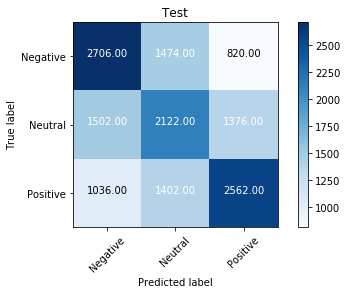

f1 score 0.49266666666666664
amazon_movies fair_balanced_100
Confusion matrix, without normalization
[[2706 1474  820]
 [1502 2122 1376]
 [1036 1402 2562]]


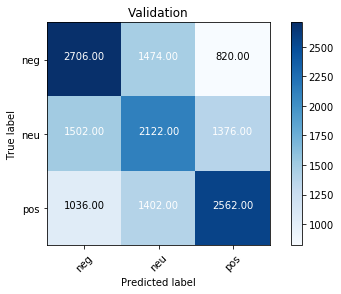

f1 score 0.49266666666666664
Accuracy 0.49266666666666664
amazon_health fair_balanced_100
Confusion matrix, without normalization
[[3304 1077  619]
 [2461 1729  810]
 [1976 1403 1621]]


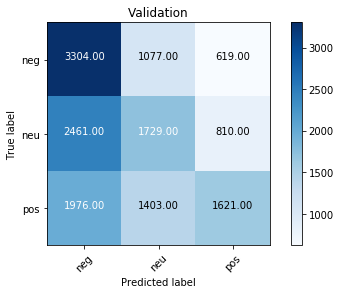

f1 score 0.4436
Accuracy 0.4436
amazon_books fair_balanced_100
Confusion matrix, without normalization
[[2585 1506  909]
 [1483 2278 1239]
 [1040 1437 2523]]


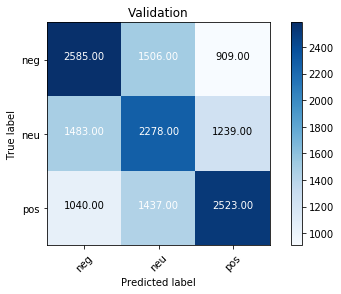

f1 score 0.4924
Accuracy 0.4924
semeval_task_a fair_balanced_100
Confusion matrix, without normalization
[[1394  686  920]
 [1199  578 1223]
 [1094  530 1376]]


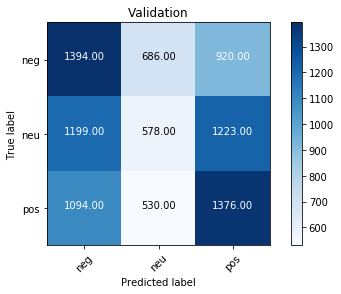

f1 score 0.372
Accuracy 0.372
semeval_task_ce fair_balanced_100
Confusion matrix, without normalization
[[444 245 311]
 [401 206 393]
 [347 199 454]]


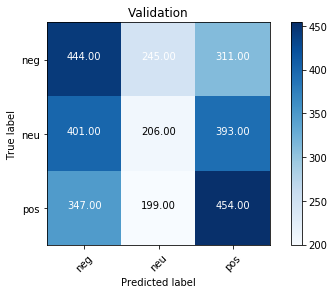

f1 score 0.368
Accuracy 0.368
Train size: 900
Test size: 15000
Confusion matrix, without normalization
[[3234 1267  499]
 [1403 2513 1084]
 [ 846 1520 2634]]


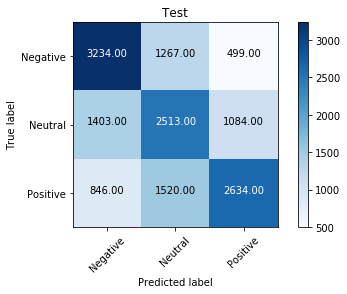

f1 score 0.5587333333333333
amazon_movies fair_balanced_100
Confusion matrix, without normalization
[[3234 1267  499]
 [1402 2514 1084]
 [ 846 1520 2634]]


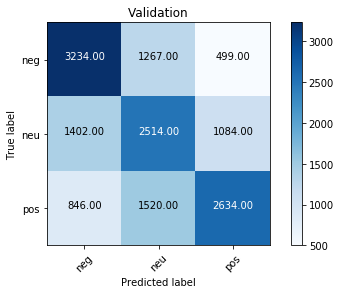

f1 score 0.5588
Accuracy 0.5588
amazon_health fair_balanced_100
Confusion matrix, without normalization
[[3266 1253  481]
 [2109 2141  750]
 [1641 1628 1731]]


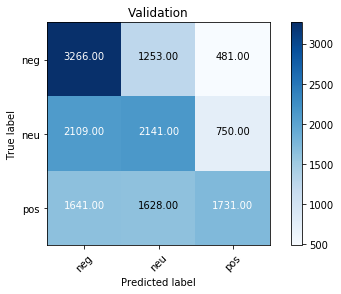

f1 score 0.47586666666666666
Accuracy 0.47586666666666666
amazon_books fair_balanced_100
Confusion matrix, without normalization
[[2700 1788  512]
 [1195 2864  941]
 [ 728 1784 2488]]


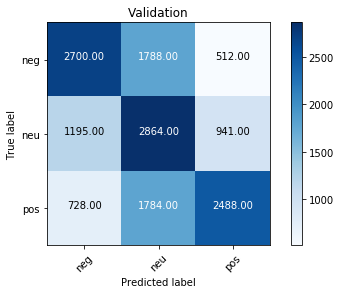

f1 score 0.5368
Accuracy 0.5368
semeval_task_a fair_balanced_100
Confusion matrix, without normalization
[[1180  930  890]
 [ 943  869 1188]
 [ 923  717 1360]]


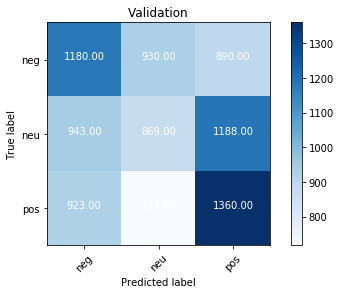

f1 score 0.37877777777777777
Accuracy 0.37877777777777777
semeval_task_ce fair_balanced_100
Confusion matrix, without normalization
[[359 321 320]
 [301 309 390]
 [302 247 451]]


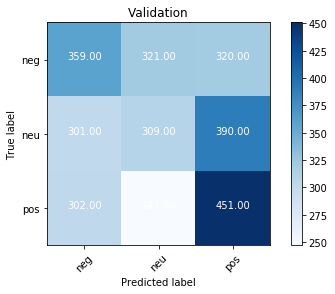

f1 score 0.373
Accuracy 0.373
Train size: 3000
Test size: 15000
Confusion matrix, without normalization
[[3488 1044  468]
 [1379 2547 1074]
 [ 586 1233 3181]]


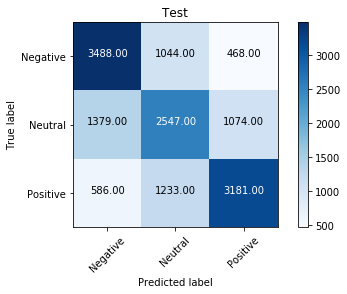

f1 score 0.6144
amazon_movies fair_balanced_100
Confusion matrix, without normalization
[[3488 1044  468]
 [1379 2547 1074]
 [ 586 1233 3181]]


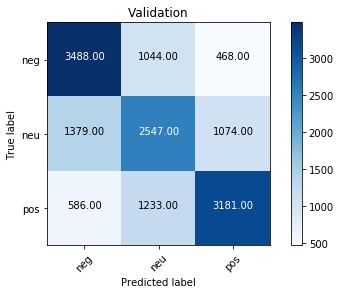

f1 score 0.6144
Accuracy 0.6144
amazon_health fair_balanced_100
Confusion matrix, without normalization
[[3561  770  669]
 [2144 1675 1181]
 [1224 1018 2758]]


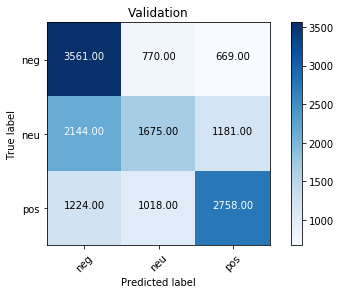

f1 score 0.5329333333333334
Accuracy 0.5329333333333334
amazon_books fair_balanced_100
Confusion matrix, without normalization
[[2971 1505  524]
 [1115 2783 1102]
 [ 488 1409 3103]]


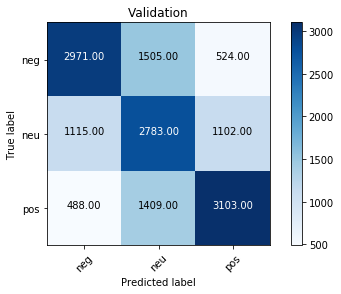

f1 score 0.5904666666666667
Accuracy 0.5904666666666667
semeval_task_a fair_balanced_100
Confusion matrix, without normalization
[[1448  662  890]
 [1098  662 1240]
 [ 969  506 1525]]


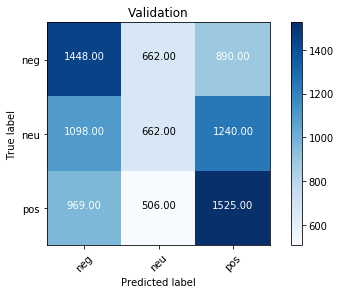

f1 score 0.40388888888888896
Accuracy 0.4038888888888889
semeval_task_ce fair_balanced_100
Confusion matrix, without normalization
[[463 230 307]
 [378 217 405]
 [356 169 475]]


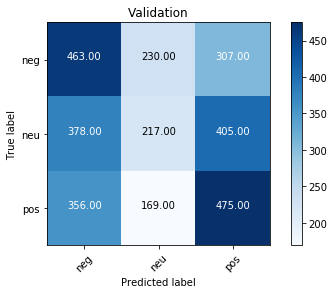

f1 score 0.38499999999999995
Accuracy 0.385
Train size: 300
Test size: 15000
Confusion matrix, without normalization
[[2615 1631  754]
 [1416 2259 1325]
 [ 989 1753 2258]]


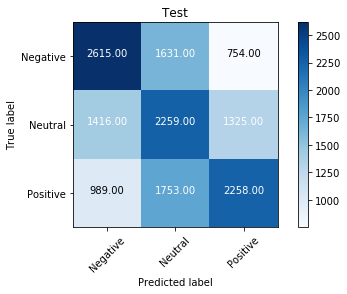

f1 score 0.47546666666666665
amazon_movies fair_balanced_100
Confusion matrix, without normalization
[[3041 1454  505]
 [2035 2258  707]
 [1875 1787 1338]]


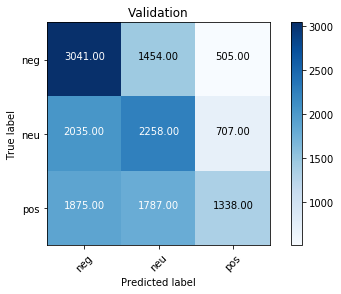

f1 score 0.4424666666666667
Accuracy 0.4424666666666667
amazon_health fair_balanced_100
Confusion matrix, without normalization
[[2615 1631  754]
 [1416 2259 1325]
 [ 989 1753 2258]]


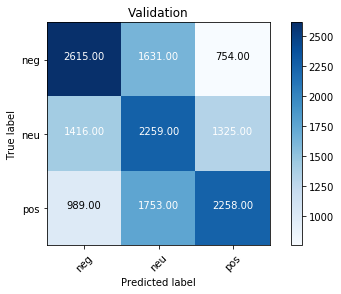

f1 score 0.47546666666666665
Accuracy 0.47546666666666665
amazon_books fair_balanced_100
Confusion matrix, without normalization
[[2875 1629  496]
 [2030 2239  731]
 [1772 1838 1390]]


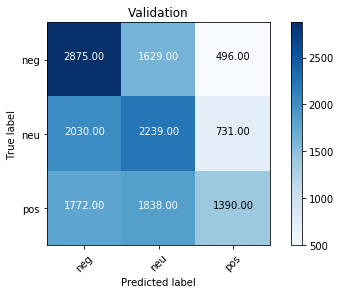

f1 score 0.43359999999999993
Accuracy 0.4336
semeval_task_a fair_balanced_100
Confusion matrix, without normalization
[[1046 1465  489]
 [1006 1436  558]
 [ 981 1185  834]]


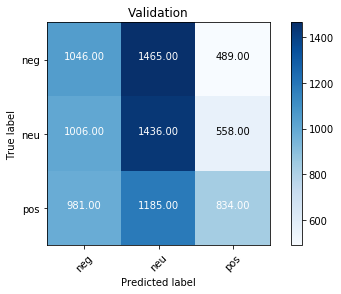

f1 score 0.36844444444444446
Accuracy 0.36844444444444446
semeval_task_ce fair_balanced_100
Confusion matrix, without normalization
[[345 508 147]
 [345 454 201]
 [324 401 275]]


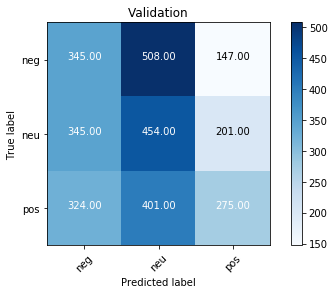

f1 score 0.35800000000000004
Accuracy 0.358
Train size: 900
Test size: 15000
Confusion matrix, without normalization
[[2823 1336  841]
 [1315 2456 1229]
 [ 635 1475 2890]]


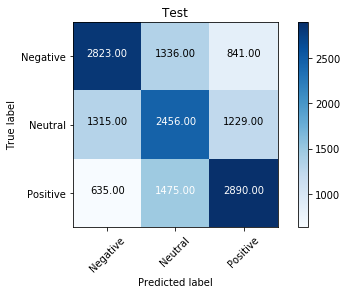

f1 score 0.5446
amazon_movies fair_balanced_100
Confusion matrix, without normalization
[[2360 1505 1135]
 [1052 2226 1722]
 [ 723 1408 2869]]


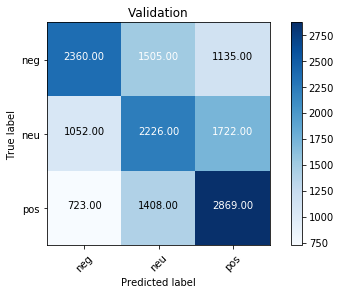

f1 score 0.497
Accuracy 0.497
amazon_health fair_balanced_100
Confusion matrix, without normalization
[[2823 1336  841]
 [1315 2456 1229]
 [ 635 1475 2890]]


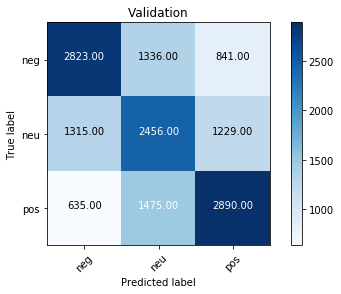

f1 score 0.5446
Accuracy 0.5446
amazon_books fair_balanced_100
Confusion matrix, without normalization
[[2204 1567 1229]
 [1148 2441 1411]
 [ 860 1466 2674]]


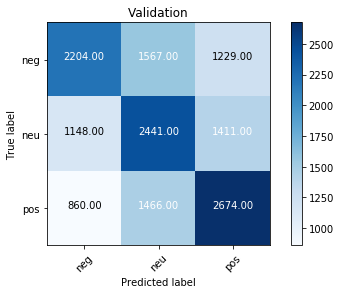

f1 score 0.48793333333333333
Accuracy 0.48793333333333333
semeval_task_a fair_balanced_100
Confusion matrix, without normalization
[[ 981  992 1027]
 [ 842  849 1309]
 [ 697  770 1533]]


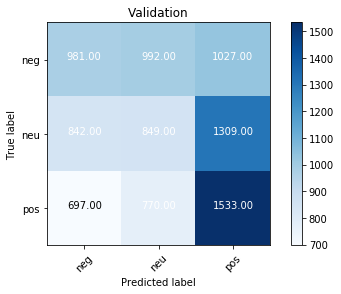

f1 score 0.37366666666666665
Accuracy 0.37366666666666665
semeval_task_ce fair_balanced_100
Confusion matrix, without normalization
[[299 301 400]
 [276 309 415]
 [264 243 493]]


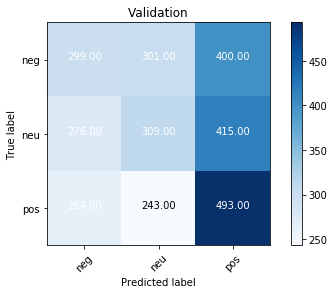

f1 score 0.367
Accuracy 0.367
Train size: 3000
Test size: 15000
Confusion matrix, without normalization
[[3058 1360  582]
 [1083 2693 1224]
 [ 475 1154 3371]]


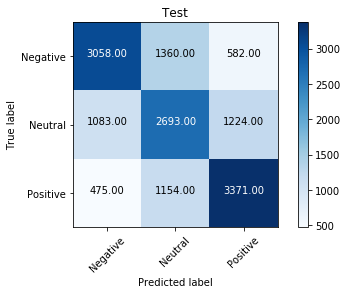

f1 score 0.6081333333333333
amazon_movies fair_balanced_100
Confusion matrix, without normalization
[[3564  870  566]
 [2060 1737 1203]
 [1415  946 2639]]


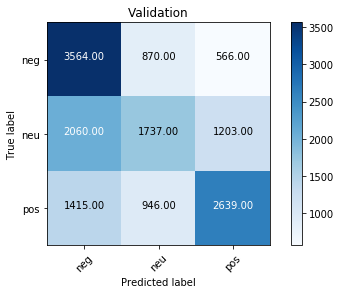

f1 score 0.5293333333333333
Accuracy 0.5293333333333333
amazon_health fair_balanced_100
Confusion matrix, without normalization
[[3058 1360  582]
 [1083 2693 1224]
 [ 475 1154 3371]]


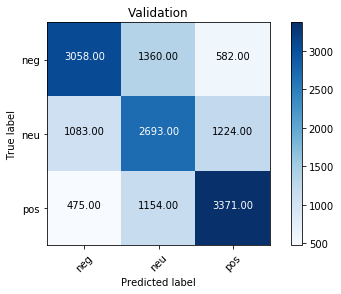

f1 score 0.6081333333333333
Accuracy 0.6081333333333333
amazon_books fair_balanced_100
Confusion matrix, without normalization
[[3399 1037  564]
 [1979 1976 1045]
 [1515  980 2505]]


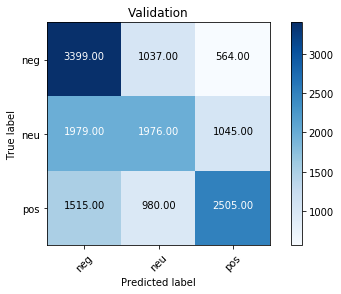

f1 score 0.5253333333333333
Accuracy 0.5253333333333333
semeval_task_a fair_balanced_100
Confusion matrix, without normalization
[[1755  631  614]
 [1771  507  722]
 [1487  467 1046]]


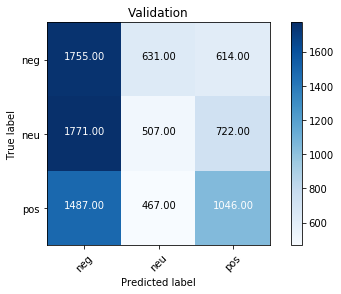

f1 score 0.3675555555555556
Accuracy 0.3675555555555556
semeval_task_ce fair_balanced_100
Confusion matrix, without normalization
[[577 215 208]
 [622 155 223]
 [486 187 327]]


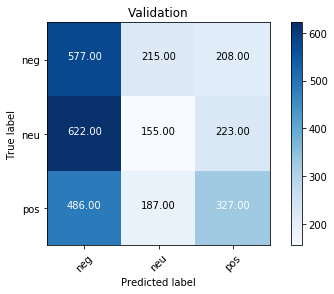

f1 score 0.353
Accuracy 0.353
Train size: 300
Test size: 15000
Confusion matrix, without normalization
[[2698 1508  794]
 [1492 2131 1377]
 [ 947 1296 2757]]


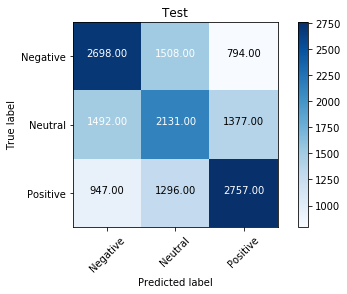

f1 score 0.5057333333333334
amazon_movies fair_balanced_100
Confusion matrix, without normalization
[[2406 1669  925]
 [1303 2454 1243]
 [ 904 1638 2458]]


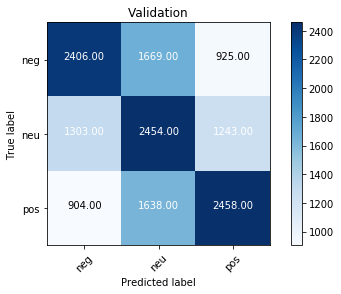

f1 score 0.4878666666666666
Accuracy 0.48786666666666667
amazon_health fair_balanced_100
Confusion matrix, without normalization
[[2257 1867  876]
 [1490 2482 1028]
 [1250 1953 1797]]


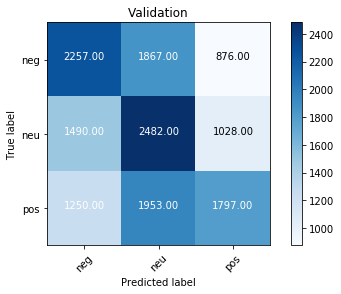

f1 score 0.4357333333333333
Accuracy 0.4357333333333333
amazon_books fair_balanced_100
Confusion matrix, without normalization
[[2698 1508  794]
 [1492 2131 1377]
 [ 947 1296 2757]]


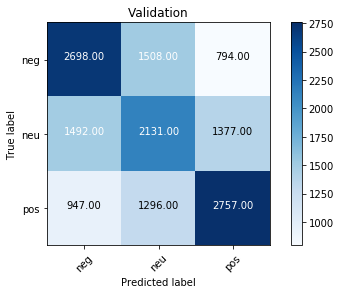

f1 score 0.5057333333333334
Accuracy 0.5057333333333334
semeval_task_a fair_balanced_100
Confusion matrix, without normalization
[[1045  757 1198]
 [ 886  627 1487]
 [ 896  494 1610]]


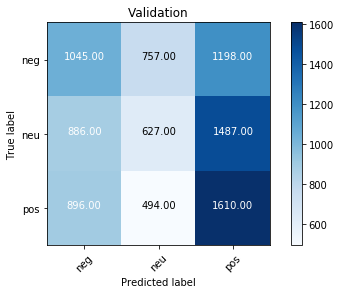

f1 score 0.36466666666666664
Accuracy 0.36466666666666664
semeval_task_ce fair_balanced_100
Confusion matrix, without normalization
[[311 262 427]
 [305 229 466]
 [278 175 547]]


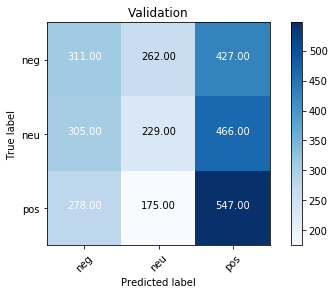

f1 score 0.36233333333333334
Accuracy 0.36233333333333334
Train size: 900
Test size: 15000
Confusion matrix, without normalization
[[3276 1224  500]
 [1615 2431  954]
 [ 842 1292 2866]]


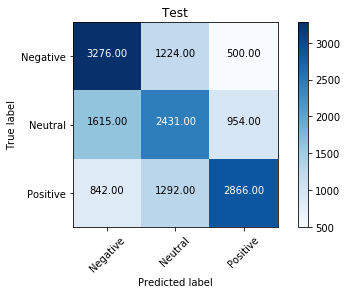

f1 score 0.5715333333333333
amazon_movies fair_balanced_100
Confusion matrix, without normalization
[[3731  867  402]
 [2135 1934  931]
 [1352 1213 2435]]


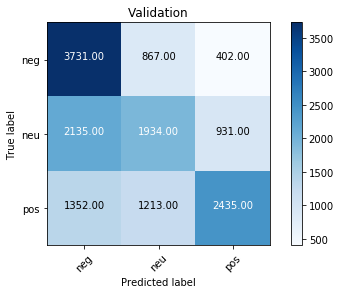

f1 score 0.54
Accuracy 0.54
amazon_health fair_balanced_100
Confusion matrix, without normalization
[[3710  991  299]
 [2793 1744  463]
 [2166 1365 1469]]


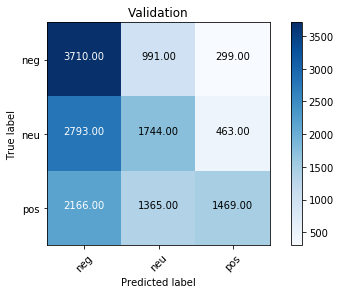

f1 score 0.46153333333333335
Accuracy 0.46153333333333335
amazon_books fair_balanced_100
Confusion matrix, without normalization
[[3277 1223  500]
 [1615 2431  954]
 [ 842 1292 2866]]


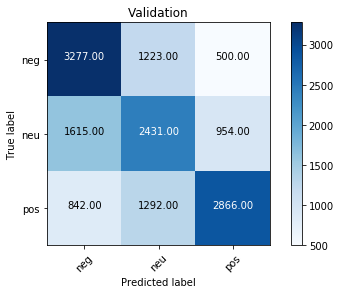

f1 score 0.5716
Accuracy 0.5716
semeval_task_a fair_balanced_100
Confusion matrix, without normalization
[[1869  374  757]
 [1830  338  832]
 [1634  264 1102]]


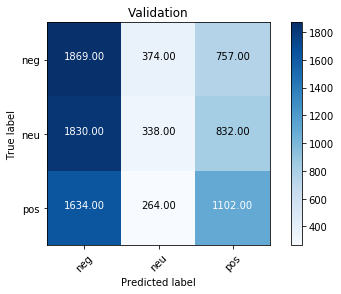

f1 score 0.36766666666666664
Accuracy 0.36766666666666664
semeval_task_ce fair_balanced_100
Confusion matrix, without normalization
[[637 103 260]
 [613 135 252]
 [551  90 359]]


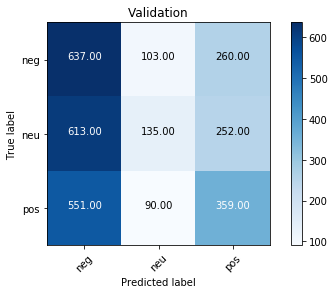

f1 score 0.377
Accuracy 0.377
Train size: 3000
Test size: 15000
Confusion matrix, without normalization
[[3401 1013  586]
 [1281 2533 1186]
 [ 573 1105 3322]]


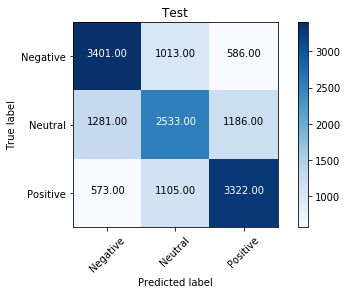

f1 score 0.6170666666666667
amazon_movies fair_balanced_100
Confusion matrix, without normalization
[[3600  875  525]
 [1637 2072 1291]
 [ 936  983 3081]]


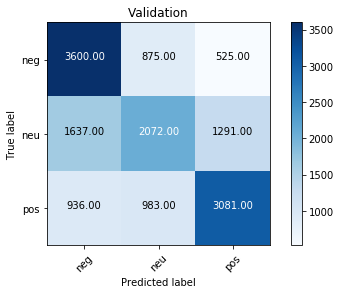

f1 score 0.5835333333333333
Accuracy 0.5835333333333333
amazon_health fair_balanced_100
Confusion matrix, without normalization
[[3739  819  442]
 [2422 1899  679]
 [1654 1279 2067]]


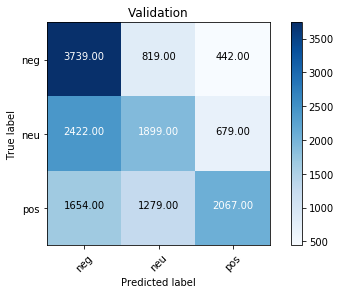

f1 score 0.5136666666666667
Accuracy 0.5136666666666667
amazon_books fair_balanced_100
Confusion matrix, without normalization
[[3401 1013  586]
 [1281 2533 1186]
 [ 573 1105 3322]]


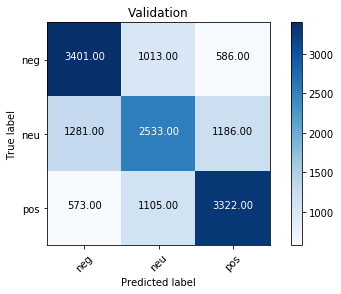

f1 score 0.6170666666666667
Accuracy 0.6170666666666667
semeval_task_a fair_balanced_100
Confusion matrix, without normalization
[[1586  410 1004]
 [1073  425 1502]
 [1034  301 1665]]


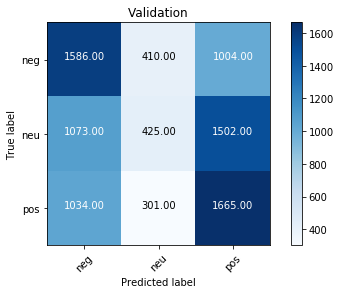

f1 score 0.40844444444444444
Accuracy 0.40844444444444444
semeval_task_ce fair_balanced_100
Confusion matrix, without normalization
[[454 166 380]
 [371 168 461]
 [366 112 522]]


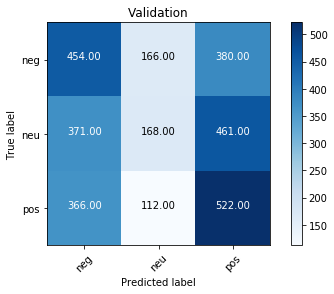

f1 score 0.38133333333333336
Accuracy 0.38133333333333336
Train size: 300
Test size: 9000
Confusion matrix, without normalization
[[1660  809  531]
 [ 921 1350  729]
 [ 682  967 1351]]


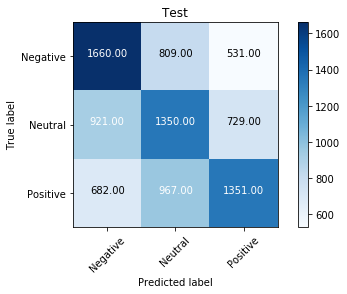

f1 score 0.4845555555555556
amazon_movies fair_balanced_100
Confusion matrix, without normalization
[[4327  137  536]
 [4110  159  731]
 [3395  201 1404]]


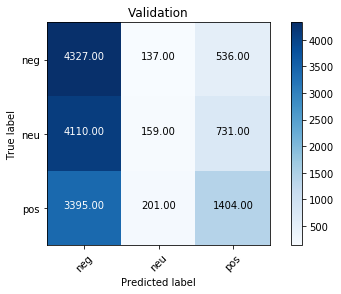

f1 score 0.39266666666666666
Accuracy 0.39266666666666666
amazon_health fair_balanced_100
Confusion matrix, without normalization
[[4133  275  592]
 [4044  299  657]
 [3313  413 1274]]


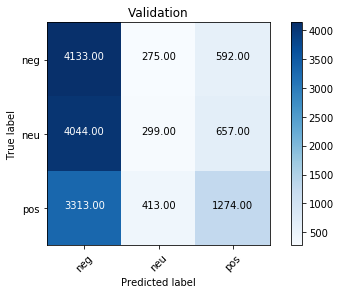

f1 score 0.38039999999999996
Accuracy 0.3804
amazon_books fair_balanced_100
Confusion matrix, without normalization
[[3997  140  863]
 [3897  173  930]
 [3016  192 1792]]


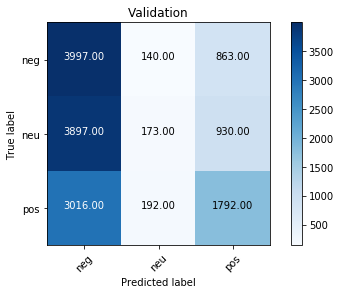

f1 score 0.3974666666666667
Accuracy 0.3974666666666667
semeval_task_a fair_balanced_100
Confusion matrix, without normalization
[[1660  809  531]
 [ 921 1350  729]
 [ 682  967 1351]]


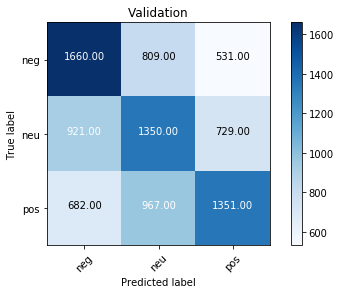

f1 score 0.4845555555555556
Accuracy 0.4845555555555556
semeval_task_ce fair_balanced_100
Confusion matrix, without normalization
[[604 239 157]
 [403 367 230]
 [255 287 458]]


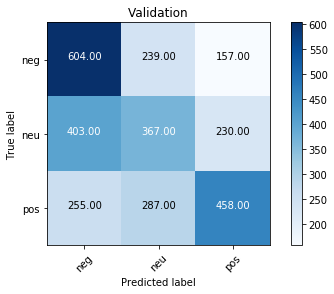

f1 score 0.47633333333333333
Accuracy 0.47633333333333333
Train size: 900
Test size: 9000
Confusion matrix, without normalization
[[1637  725  638]
 [ 819 1261  920]
 [ 533  713 1754]]


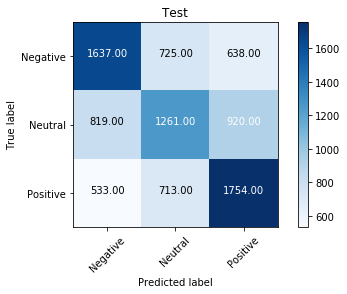

f1 score 0.5168888888888888
amazon_movies fair_balanced_100
Confusion matrix, without normalization
[[4156  102  742]
 [3996   96  908]
 [3079   87 1834]]


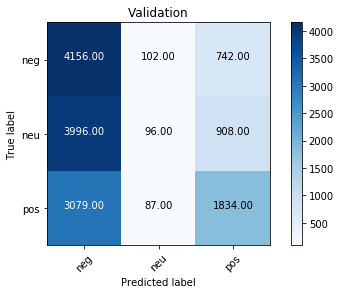

f1 score 0.40573333333333333
Accuracy 0.40573333333333333
amazon_health fair_balanced_100
Confusion matrix, without normalization
[[4502  150  348]
 [4486  105  409]
 [3836  127 1037]]


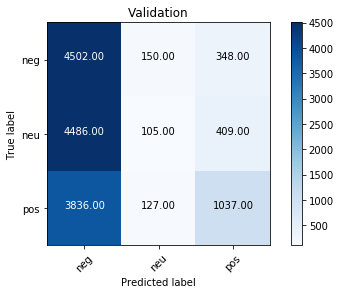

f1 score 0.37626666666666675
Accuracy 0.3762666666666667
amazon_books fair_balanced_100
Confusion matrix, without normalization
[[4713   79  208]
 [4540   92  368]
 [3912  106  982]]


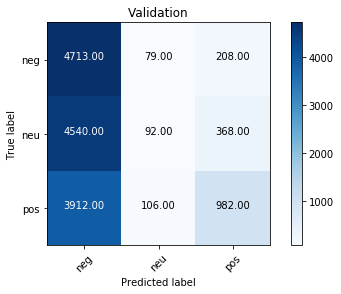

f1 score 0.3857999999999999
Accuracy 0.3858
semeval_task_a fair_balanced_100
Confusion matrix, without normalization
[[1588  769  643]
 [ 784 1299  917]
 [ 509  749 1742]]


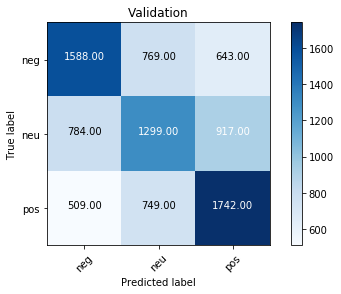

f1 score 0.5143333333333333
Accuracy 0.5143333333333333
semeval_task_ce fair_balanced_100
Confusion matrix, without normalization
[[580 266 154]
 [337 412 251]
 [213 258 529]]


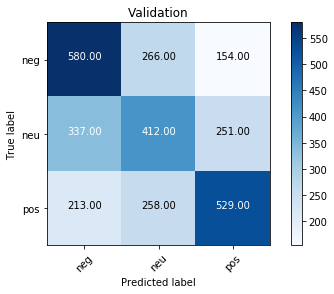

f1 score 0.507
Accuracy 0.507
Train size: 3000
Test size: 9000
Confusion matrix, without normalization
[[1884  592  524]
 [ 776 1321  903]
 [ 436  642 1922]]


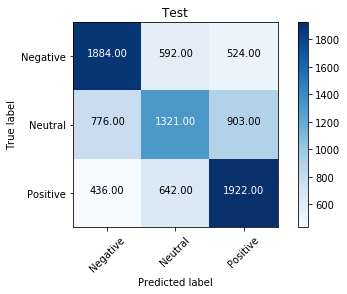

f1 score 0.5696666666666667
amazon_movies fair_balanced_100
Confusion matrix, without normalization
[[4437   99  464]
 [4122   93  785]
 [3051  116 1833]]


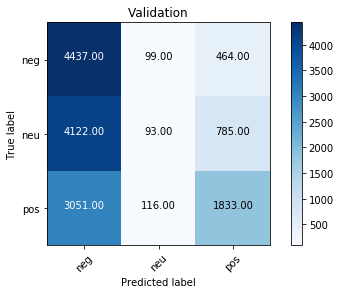

f1 score 0.4242
Accuracy 0.4242
amazon_health fair_balanced_100
Confusion matrix, without normalization
[[4596   83  321]
 [4527   85  388]
 [3761  102 1137]]


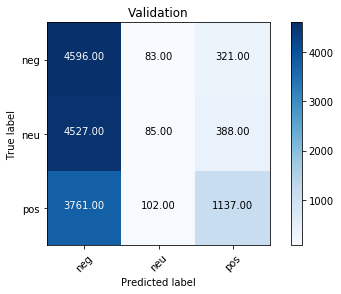

f1 score 0.3878666666666667
Accuracy 0.3878666666666667
amazon_books fair_balanced_100
Confusion matrix, without normalization
[[4739   32  229]
 [4535   53  412]
 [3789   60 1151]]


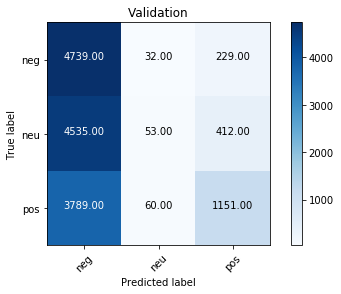

f1 score 0.3962
Accuracy 0.3962
semeval_task_a fair_balanced_100
Confusion matrix, without normalization
[[1877  595  528]
 [ 768 1323  909]
 [ 432  641 1927]]


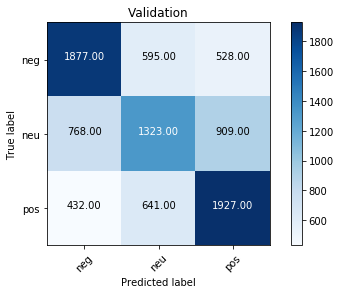

f1 score 0.5696666666666667
Accuracy 0.5696666666666667
semeval_task_ce fair_balanced_100
Confusion matrix, without normalization
[[709 187 104]
 [354 422 224]
 [163 207 630]]


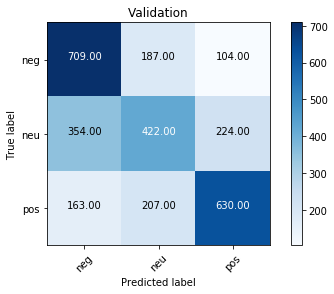

f1 score 0.587
Accuracy 0.587
Train size: 300
Test size: 3000
Confusion matrix, without normalization
[[405 263 332]
 [234 294 472]
 [131 226 643]]


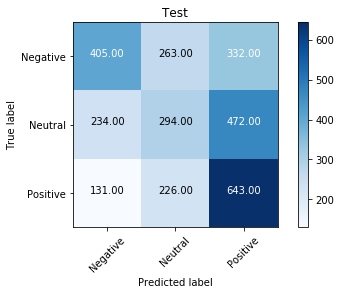

f1 score 0.44733333333333336
amazon_movies fair_balanced_100
Confusion matrix, without normalization
[[2210 1604 1186]
 [2402 1326 1272]
 [1837 1179 1984]]


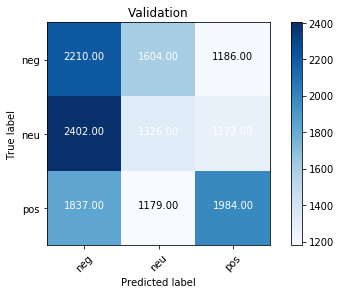

f1 score 0.368
Accuracy 0.368
amazon_health fair_balanced_100
Confusion matrix, without normalization
[[1848 2400  752]
 [2122 2150  728]
 [1655 1907 1438]]


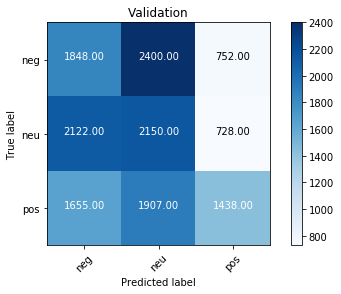

f1 score 0.3624
Accuracy 0.3624
amazon_books fair_balanced_100
Confusion matrix, without normalization
[[2314 2074  612]
 [2519 1817  664]
 [1962 1765 1273]]


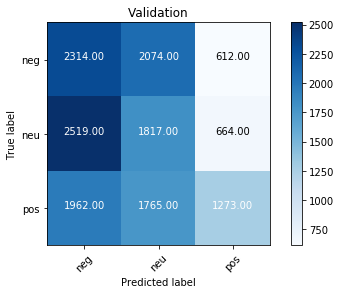

f1 score 0.3602666666666667
Accuracy 0.3602666666666667
semeval_task_a fair_balanced_100
Confusion matrix, without normalization
[[1064  819 1117]
 [ 518  889 1593]
 [ 349  617 2034]]


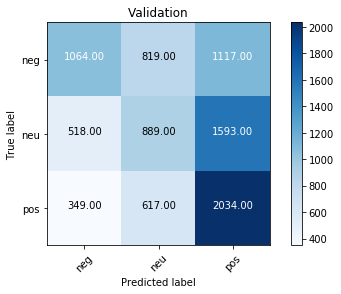

f1 score 0.443
Accuracy 0.443
semeval_task_ce fair_balanced_100
Confusion matrix, without normalization
[[405 263 332]
 [234 294 472]
 [131 226 643]]


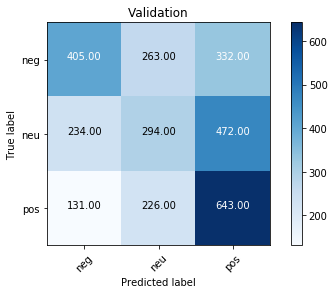

f1 score 0.44733333333333336
Accuracy 0.44733333333333336
Train size: 900
Test size: 3000
Confusion matrix, without normalization
[[394 355 251]
 [238 419 343]
 [116 266 618]]


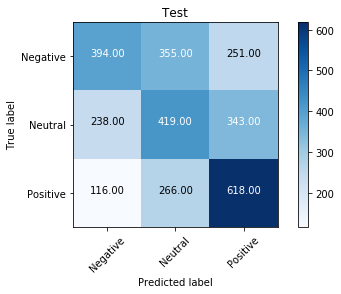

f1 score 0.477
amazon_movies fair_balanced_100
Confusion matrix, without normalization
[[2629  292 2079]
 [2411  340 2249]
 [1688  360 2952]]


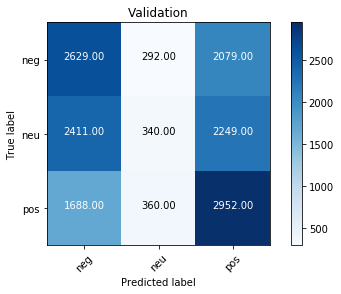

f1 score 0.3947333333333333
Accuracy 0.3947333333333333
amazon_health fair_balanced_100
Confusion matrix, without normalization
[[2450  252 2298]
 [2343  204 2453]
 [1747  216 3037]]


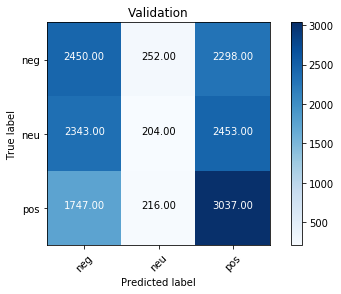

f1 score 0.3794
Accuracy 0.3794
amazon_books fair_balanced_100
Confusion matrix, without normalization
[[2500  271 2229]
 [2285  309 2406]
 [1768  337 2895]]


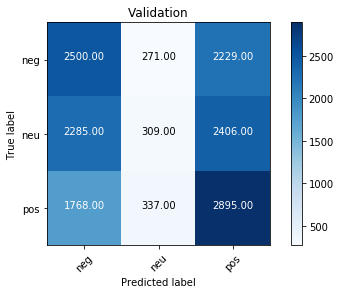

f1 score 0.38026666666666664
Accuracy 0.38026666666666664
semeval_task_a fair_balanced_100
Confusion matrix, without normalization
[[1115  859 1026]
 [ 471 1333 1196]
 [ 280  705 2015]]


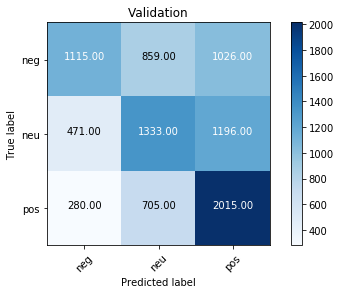

f1 score 0.4958888888888889
Accuracy 0.4958888888888889
semeval_task_ce fair_balanced_100
Confusion matrix, without normalization
[[380 359 261]
 [231 421 348]
 [114 263 623]]


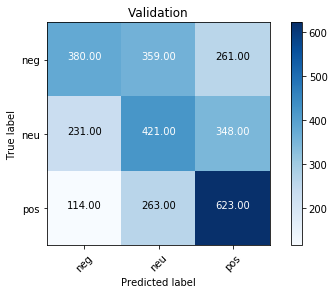

f1 score 0.4746666666666667
Accuracy 0.4746666666666667
Train size: 3000
Test size: 3000
Confusion matrix, without normalization
[[551 208 241]
 [287 355 358]
 [158 222 620]]


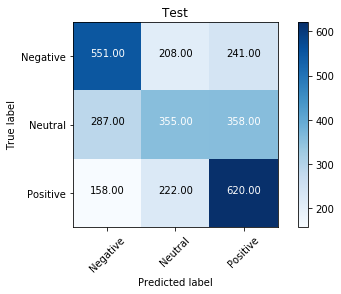

f1 score 0.5086666666666667
amazon_movies fair_balanced_100
Confusion matrix, without normalization
[[3113  566 1321]
 [2837  644 1519]
 [1988  536 2476]]


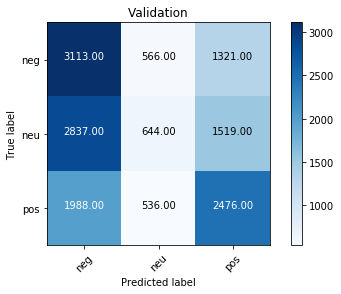

f1 score 0.41553333333333325
Accuracy 0.4155333333333333
amazon_health fair_balanced_100
Confusion matrix, without normalization
[[2958  414 1628]
 [2742  378 1880]
 [2029  349 2622]]


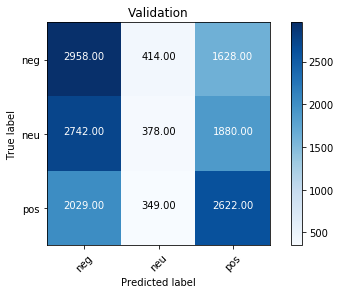

f1 score 0.3972
Accuracy 0.3972
amazon_books fair_balanced_100
Confusion matrix, without normalization
[[3005  613 1382]
 [2843  591 1566]
 [2262  612 2126]]


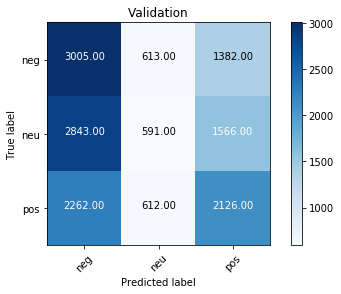

f1 score 0.3814666666666667
Accuracy 0.3814666666666667
semeval_task_a fair_balanced_100
Confusion matrix, without normalization
[[1499  653  848]
 [ 568 1202 1230]
 [ 282  550 2168]]


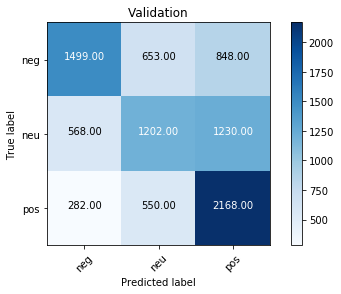

f1 score 0.541
Accuracy 0.541
semeval_task_ce fair_balanced_100
Confusion matrix, without normalization
[[551 206 243]
 [288 351 361]
 [157 215 628]]


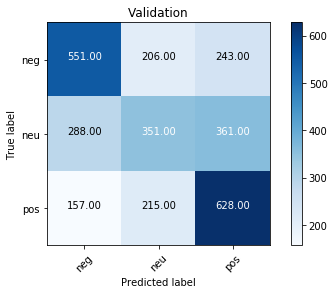

f1 score 0.51
Accuracy 0.51


In [3]:
tasks = ['amazon_movies', 'amazon_health', 'amazon_books', 'semeval_task_a', 'semeval_task_ce']
sub_tasks = ['fair_balanced_100', 'fair_balanced_300', 'fair_balanced_1000'] #'fair_unbalanced_100', 'fair_unbalanced_300', 'fair_unbalanced_1000'

hyper_map = {'amazon':{'fair_balanced_100':{'f':80, 'arc': 'ngrams bernoulli'}, 'fair_balanced_300':{'f':80, 'arc': 'ngrams bernoulli'}, 'fair_balanced_1000':{'f':30, 'arc': 'ngrams bernoulli'}},
             'semeval':{'fair_balanced_100':{'f':20, 'arc': 'original'}, 'fair_balanced_300':{'f':20, 'arc': 'original'}, 'fair_balanced_1000':{'f':20, 'arc': 'original'}}}

stemmer = Stemmer()

print(negate_sequence_stem("i was hoping this wouldn't be over quickly", stemmer))
print(negate_sequence_stem("can't we all just be friends?", stemmer))

notebook_dir = pathlib.Path.cwd()
repo_dir = notebook_dir.parent
datasets_dir = repo_dir / "datasets"

for task in tasks:
    for subtask in sub_tasks:
        df_trn = pd.read_csv("datasets/"+task+"/"+subtask+"/train.csv")
        df_val = pd.read_csv("datasets/"+task+"/"+subtask+"/validate.csv")
        df_tst = pd.read_csv("datasets/"+task+"/"+subtask+"/test.csv")
        
        arc = hyper_map[task.split('_')[0]][subtask]['arc']
        f = hyper_map[task.split('_')[0]][subtask]['f']

        print("Train size:", len(df_trn))
        print("Test size:", len(df_tst))
        
        df_trn['text'] = df_trn['text'].astype(str)
        df_tst['text'] = df_tst['text'].astype(str)

        df_trn['text'] = df_trn['text'].apply(lambda e: clean_text_for_language_model(e, 
                                                                                      remove_users=True, 
                                                                                      remove_urls=True, 
                                                                                      remove_numbers=True))
        df_tst['text'] = df_tst['text'].apply(lambda e: clean_text_for_language_model(e, 
                                                                                      remove_users=True, 
                                                                                      remove_urls=True, 
                                                                                      remove_numbers=True))

        tier = int(subtask.split('_')[-1])
        if arc == 'ngrams bernoulli':
            cv = CountVectorizer(stop_words=None, 
                                 ngram_range=(1,3),
                                 max_features=30*tier,
                                 tokenizer=lambda e: tokenizer_word(e,
                                                                    keep_phrases=False,
                                                                    tokenize_punc=True,
                                                                    split_clitics=False,
                                                                    keep_preceeding_space=False),
                                 binary=True)

            cv_data_trn = cv.fit_transform(df_trn["text"])
            cv_data_tst = cv.transform(df_tst["text"])

            model = MultinomialNB(alpha=1.0, 
                                  fit_prior=True, 
                                  class_prior=None)
        if arc == 'original':
            cv = CountVectorizer(stop_words=None, 
                                 ngram_range=(1,1),
                                 max_features=30*tier,
                                 tokenizer=lambda e: tokenizer_word(e,
                                                                    keep_phrases=False,
                                                                    tokenize_punc=True,
                                                                    split_clitics=False,
                                                                    keep_preceeding_space=False),
                                 binary=False)

            cv_data_trn = cv.fit_transform(df_trn["text"])
            cv_data_tst = cv.transform(df_tst["text"])

            model = MultinomialNB(alpha=1.0, 
                                  fit_prior=True, 
                                  class_prior=None)

        model.fit(cv_data_trn, df_trn['label'])
        
        preds = model.predict(cv_data_tst)
        cm_test = confusion_matrix(y_true=df_tst["label"], y_pred=preds)
        plot_confusion_matrix(cm_test,
                              ['Negative', 'Neutral', 'Positive'],
                              normalize=False,
                              title='Test')
        print("f1 score", f1_score(df_tst["label"], preds, average="micro"))
        
        new_col_name = ".".join(['naive_bayes', subtask.split('_')[-1], task])
        for task_tst in tasks:
            subtask_tst = 'fair_balanced_100'
            df_tst = pd.read_csv("datasets/"+task_tst+"/"+subtask_tst+"/test.csv")
            df_tst['text'] = df_tst['text'].astype(str)
            df_tst['text'] = df_tst['text'].apply(lambda e: clean_text_for_language_model(e, 
                                                                              remove_users=True, 
                                                                              remove_urls=True, 
                                                                              remove_numbers=True))
            print(task_tst, subtask_tst)

            cv_data_tst = cv.transform(df_tst["text"])
            preds = model.predict(cv_data_tst)

            cm_test = confusion_matrix(y_true=df_tst["label"], y_pred=preds)
            plot_confusion_matrix(cm_test,
                                ['neg', 'neu', 'pos'],
                                normalize=False,
                                title='Validation')
            print("f1 score", f1_score(df_tst["label"], preds, average="micro"))
            print("Accuracy", accuracy_score(df_tst["label"], preds))

            df_tst[new_col_name] = preds

            df_tst.to_csv("datasets/"+task_tst+"/"+subtask_tst+"/test.csv", index=False, quoting=csv.QUOTE_ALL, encoding='utf-8')

['i', 'was', 'hope', 'this', 'not_b', 'over', 'quick']
['not_w', 'all', 'just', 'be', 'friend', '?']
Train size: 300
Test size: 15000
Confusion matrix, without normalization
[[  333    54  1723]
 [   98    74  1346]
 [  168   150 11054]]


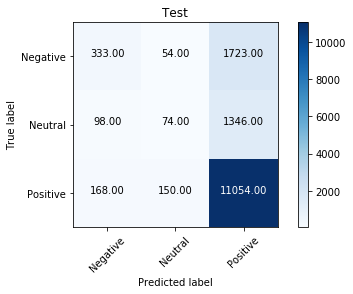

f1 score 0.7640666666666667
Train size: 900
Test size: 15000
Confusion matrix, without normalization
[[  362    71  1677]
 [   67    94  1357]
 [  103   140 11129]]


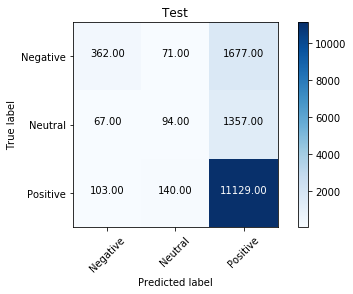

f1 score 0.7723333333333333
Train size: 3000
Test size: 15000
Confusion matrix, without normalization
[[  967    36  1107]
 [  260    69  1189]
 [  254    45 11073]]


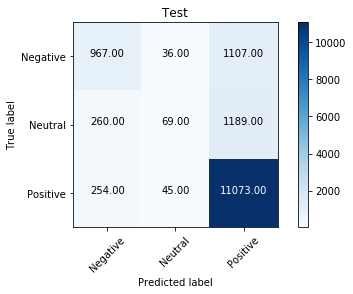

f1 score 0.8072666666666667
Train size: 300
Test size: 15000
Confusion matrix, without normalization
[[   55    16  1469]
 [   24    19  1367]
 [   33    21 11996]]


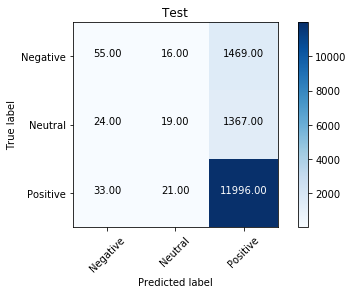

f1 score 0.8046666666666666
Train size: 900
Test size: 15000
Confusion matrix, without normalization
[[   69    13  1458]
 [   17    19  1374]
 [   19    18 12013]]


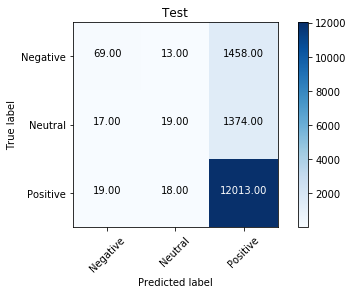

f1 score 0.8067333333333333
Train size: 3000
Test size: 15000
Confusion matrix, without normalization
[[  232    18  1290]
 [   55    24  1331]
 [   24    20 12006]]


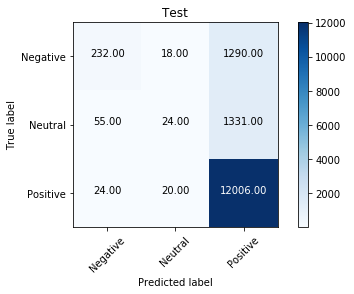

f1 score 0.8174666666666667
Train size: 300
Test size: 15000
Confusion matrix, without normalization
[[   35   138  1382]
 [   18   151  1520]
 [   29   256 11471]]


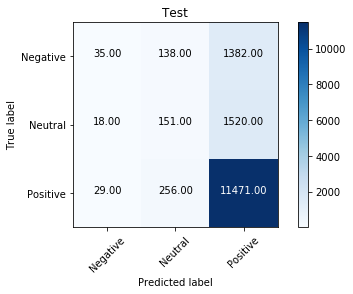

f1 score 0.7771333333333335
Train size: 900
Test size: 15000
Confusion matrix, without normalization
[[   51    91  1413]
 [   12   103  1574]
 [    7    69 11680]]


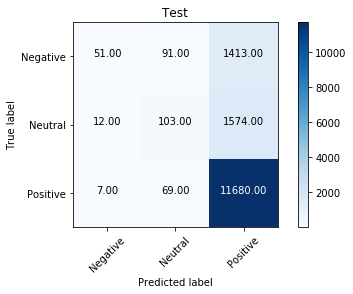

f1 score 0.7889333333333334
Train size: 3000
Test size: 15000
Confusion matrix, without normalization
[[  337   169  1049]
 [   80   223  1386]
 [   54   131 11571]]


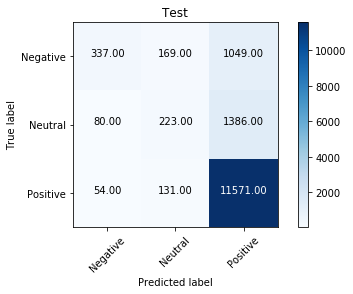

f1 score 0.8087333333333333
Train size: 300
Test size: 29632
Confusion matrix, without normalization
[[  51 2389 1904]
 [  63 8462 4869]
 [  38 4670 7186]]


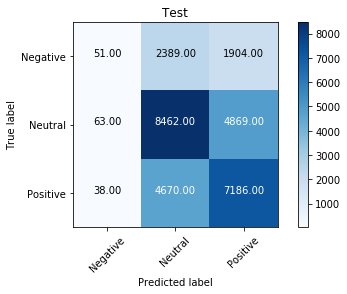

f1 score 0.5297988660907127
Train size: 900
Test size: 29632
Confusion matrix, without normalization
[[  38 2837 1469]
 [  28 9305 4061]
 [  11 4581 7302]]


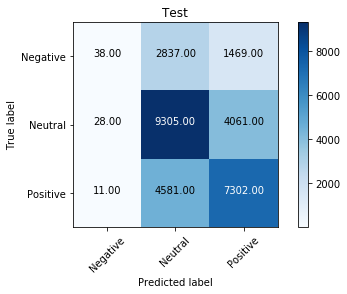

f1 score 0.5617238120950324
Train size: 3000
Test size: 29632
Confusion matrix, without normalization
[[ 155 2861 1328]
 [  98 9153 4143]
 [  30 3717 8147]]


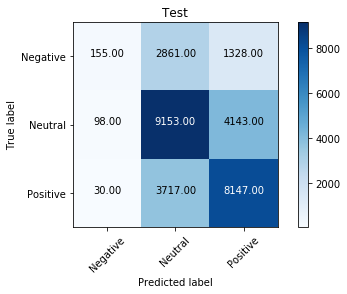

f1 score 0.5890591252699784
Train size: 300
Test size: 8763
Confusion matrix, without normalization
[[   0  408  765]
 [   0 1274 2302]
 [   1  953 3060]]


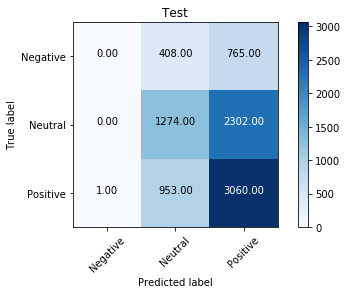

f1 score 0.494579481912587
Train size: 900
Test size: 8763
Confusion matrix, without normalization
[[   2  713  458]
 [   1 2066 1509]
 [   0 1309 2705]]


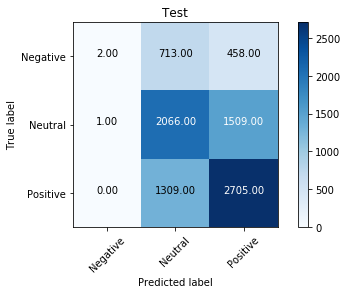

f1 score 0.5446764806573091
Train size: 3000
Test size: 8763
Confusion matrix, without normalization
[[   6  800  367]
 [   2 2132 1442]
 [   1 1186 2827]]


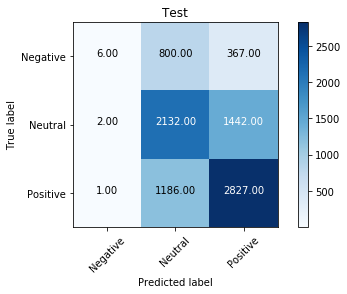

f1 score 0.5665867853474837


In [5]:
tasks = ['amazon_movies', 'amazon_health', 'amazon_books', 'semeval_task_a', 'semeval_task_ce']
sub_tasks = ['fair_unbalanced_100', 'fair_unbalanced_300', 'fair_unbalanced_1000']

hyper_map = {'amazon':{'fair_unbalanced_100':{'f':80, 'arc': 'ngrams bernoulli'}, 'fair_unbalanced_300':{'f':80, 'arc': 'ngrams bernoulli'}, 'fair_unbalanced_1000':{'f':30, 'arc': 'ngrams bernoulli'}},
             'semeval':{'fair_unbalanced_100':{'f':20, 'arc': 'original'}, 'fair_unbalanced_300':{'f':20, 'arc': 'original'}, 'fair_unbalanced_1000':{'f':20, 'arc': 'original'}}}

stemmer = Stemmer()

print(negate_sequence_stem("i was hoping this wouldn't be over quickly", stemmer))
print(negate_sequence_stem("can't we all just be friends?", stemmer))

notebook_dir = pathlib.Path.cwd()
repo_dir = notebook_dir.parent
datasets_dir = repo_dir / "datasets"

for task in tasks:
    for subtask in sub_tasks:
        df_trn = pd.read_csv("datasets/"+task+"/"+subtask+"/train.csv")
        df_val = pd.read_csv("datasets/"+task+"/"+subtask+"/validate.csv")
        df_tst = pd.read_csv("datasets/"+task+"/fair_unbalanced_100/test.csv")
        
        arc = hyper_map[task.split('_')[0]][subtask]['arc']
        f = hyper_map[task.split('_')[0]][subtask]['f']

        print("Train size:", len(df_trn))
        print("Test size:", len(df_tst))
        
        df_trn['text'] = df_trn['text'].astype(str)
        df_tst['text'] = df_tst['text'].astype(str)

        df_trn['text'] = df_trn['text'].apply(lambda e: clean_text_for_language_model(e, 
                                                                                      remove_users=True, 
                                                                                      remove_urls=True, 
                                                                                      remove_numbers=True))
        df_tst['text'] = df_tst['text'].apply(lambda e: clean_text_for_language_model(e, 
                                                                                      remove_users=True, 
                                                                                      remove_urls=True, 
                                                                                      remove_numbers=True))

        tier = int(subtask.split('_')[-1])
        if arc == 'ngrams bernoulli':
            cv = CountVectorizer(stop_words=None, 
                                 ngram_range=(1,3),
                                 max_features=30*tier,
                                 tokenizer=lambda e: tokenizer_word(e,
                                                                    keep_phrases=False,
                                                                    tokenize_punc=True,
                                                                    split_clitics=False,
                                                                    keep_preceeding_space=False),
                                 binary=True)

            cv_data_trn = cv.fit_transform(df_trn["text"])
            cv_data_tst = cv.transform(df_tst["text"])

            model = MultinomialNB(alpha=1.0, 
                                  fit_prior=True, 
                                  class_prior=None)
        if arc == 'original':
            cv = CountVectorizer(stop_words=None, 
                                 ngram_range=(1,1),
                                 max_features=30*tier,
                                 tokenizer=lambda e: tokenizer_word(e,
                                                                    keep_phrases=False,
                                                                    tokenize_punc=True,
                                                                    split_clitics=False,
                                                                    keep_preceeding_space=False),
                                 binary=False)

            cv_data_trn = cv.fit_transform(df_trn["text"])
            cv_data_tst = cv.transform(df_tst["text"])

            model = MultinomialNB(alpha=1.0, 
                                  fit_prior=True, 
                                  class_prior=None)

        model.fit(cv_data_trn, df_trn['label'])
        
        preds = model.predict(cv_data_tst)
        cm_test = confusion_matrix(y_true=df_tst["label"], y_pred=preds)
        plot_confusion_matrix(cm_test,
                              ['Negative', 'Neutral', 'Positive'],
                              normalize=False,
                              title='Test')
        print("f1 score", f1_score(df_tst["label"], preds, average="micro"))
        
        new_col_name = ".".join(['naive_bayes', subtask.split('_')[-1], task])

        df_tst[new_col_name] = preds

        df_tst.to_csv("datasets/"+task+"/fair_unbalanced_100/test.csv", index=False, quoting=csv.QUOTE_ALL, encoding='utf-8')

In [0]:
subtask_tst = 'fair_unbalanced_100'
df_tst = pd.read_csv("/content/gdrive/My Drive/Data Science/Low Shot NLP/datasets/semeval_task_a/"+subtask_tst+"/test.csv")
df_tst['text'] = df_tst['text'].astype(str)
df_tst['text'] = df_tst['text'].apply(lambda e: clean_text_for_language_model(e, 
                                                                  remove_users=True, 
                                                                  remove_urls=True, 
                                                                  remove_numbers=True))

In [18]:
df_trn[df_trn['text'].isna()]

,label,text


In [7]:
subtask_tst = 'fair_unbalanced_1000'
df_tst = pd.read_csv("datasets/amazon_movies/"+subtask_tst+"/test.csv")
df_tst.columns

Index(['label', 'text', 'svm.1000.amazon_movies',
       'naive_bayes.1000.amazon_movies'],
      dtype='object')